# Pytorch3D-Me Demo

A [Pytorch3D](https://github.com/facebookresearch/pytorch3d) 0.6.1 extension with features introduced in [FitMe](https://github.com/lattas/FitMe) (CVPR 2023) and [AvatarMe++](https://github.com/lattas/avatarme) (TPAMI 2021), which introduces additional functionality in texturing and shading. In detail we add:
- A renderer object for rendering directly in UV-space,
- A blinn-phong based shader,
- The option to use multiple reflectance textures with a single mesh, including Diffuse Albedo, Specular Albedo, Diffuse Normals, Specular Normals and Occlusion Shadow,
- Spatially-varying specular shininess,
- Subsurface-scattering approximation with spatially-varying translucency,
- Multiple Point and Directional lights per rendered batch item.

## Imports

In [42]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch, pytorch3d
from pytorch3d.io import load_objs_as_meshes, load_objs_and_textures
from pytorch3d.structures import join_meshes_as_scene, Meshes
from pytorch3d.renderer import (
    Textures, TexturesUV,
    look_at_view_transform,
    PointLights, DirectionalLights,
    FoVOrthographicCameras, FoVPerspectiveCameras,
    RasterizationSettings,
    MeshRenderer, MeshRasterizer,
    SoftPhongShader, MultiTexturedSoftPhongShader
)
from pytorch3d.io import save_obj

In [4]:
device = torch.device("cuda:0")

## Helper Functions

In [93]:
def show(img, figsize=(7,7)):
    
    if type(img) == list:
        img = [i.squeeze().cpu().numpy() for i in img]
        img = np.concatenate(img, axis=1)
        
    if isinstance(img, type(torch.Tensor())):
        img = img.squeeze().cpu().numpy()
    
    plt.figure(figsize=figsize)
    plt.imshow(np.clip(img,0,1))
    plt.axis("off");
        
def load_texture_pt3d(img_path, device):
    img_cpu = np.array(Image.open(img_path))/255.
    img_gpu = torch.Tensor([img_cpu]).to(device)
    return img_gpu[..., :3]

## A. Vanilla Rendering

### Load and Visualize Input

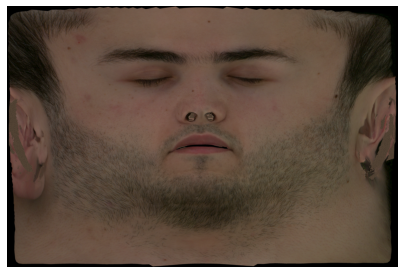

In [94]:
# Define Paths
mesh_dir = ['../assets/subject1/s1.obj']

# Load
meshes = load_objs_as_meshes(mesh_dir).to(device)

# Visualize Texture
show(meshes.textures._maps_padded)

### Define Renderer

In [95]:
# Define a standard pytorch3d renderer with point lights
lights = PointLights(device=device,
            location=[[0.8, 0.8, 2]],
            ambient_color=[[0.7, 0.7, 0.7]],
            diffuse_color=[[1.0, 1.0, 1.0]],
            specular_color=[[0.2, 0.2, 0.2]])

dist, elev, azim, fov = -2.2, 0.0, 180, 60
R, T = look_at_view_transform(dist=dist, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, fov=fov)

raster_settings = RasterizationSettings(
    image_size=1024,
    blur_radius=0.0,
    faces_per_pixel=1,
)

# Use a SoftPhongShader
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, cameras=cameras, lights=lights
    )
)

### Render

took 0.07 seconds


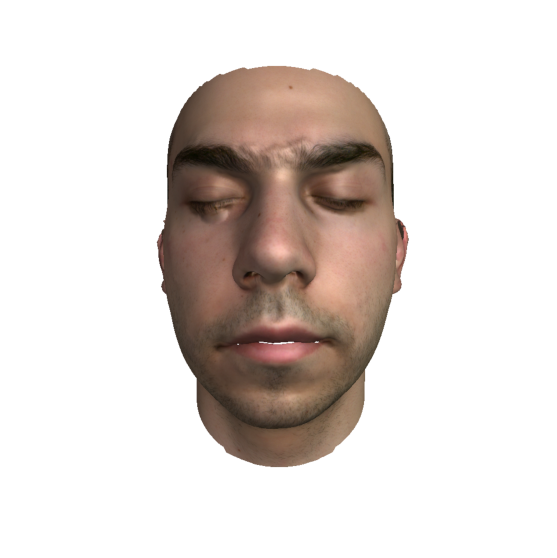

In [96]:
t = time.time()
images = renderer(meshes)
print('took {} seconds'.format(round(time.time()-t, 2)))
show(images[0, ..., :3], figsize=(10,10))

## B. Pytorch3D-Me Render
Here we can set multiple reflectance maps, multiple lights sources,
and use our Blinn-Phong shader and Subsurface Scattering approximation, with spatially varying translucency and roughness.

### Load and Visualize Input

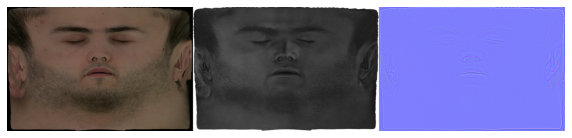

In [97]:
# subject-specific materials 
mesh_dir = ['../assets/subject1/s1.obj']
da_dir = ['../assets/subject1/s1.png']
sa_dir = ['../assets/subject1/s1_specAlbedo.png']
dn_dir = ['../assets/subject1/s1_shapeNormals.png']
sn_dir = ['../assets/subject1/s1_tangentNormals.png']

# subject-agnostic materials
sh_dir = ['../assets/common/shininess.png']
tr_dir = ['../assets/common/translucency.png']

# Load mesh and textures
meshes = load_objs_and_textures(mesh_dir,
                    diffAlbedos=da_dir, specAlbedos=sa_dir,
                    specNormals=sn_dir,
                    shininess=sh_dir, translucency=tr_dir,
                    device=device)

# Visualize textures
show([
    meshes.textures._diffAlbedo_padded[0], 
    meshes.textures._specAlbedo_padded[0],
    meshes.textures._specNormals_padded[0]
], figsize=(10,10))

### Define Renderer

In [98]:
# In Pytorch3d-Me we can set multiple light sources per batch item
lights = PointLights(device=device,
            location=[[
                [1.7, 0.0, 2.0],
                [-1.7, 0.0, 2.0],
            ]],
            ambient_color=[
                [0.3, 0.3, 0.3]],
            diffuse_color=[[
                [0.2, 0.2, 0.2],
                [0.1, 0.2, 0.3]]],
            specular_color=[[
                [0.2, 0.2, 0.2],
                [0.1, 0.2, 0.3]]])

dist, elev, azim, fov = -2.2, 0.0, 180, 60
R, T = look_at_view_transform(dist=dist, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, fov=fov)

raster_settings = RasterizationSettings(
    image_size=1024,
    blur_radius=0.0,
    faces_per_pixel=1,
)

# Set a renderer with MultiTexturedSoftPhongShader
# blinn_phong highlights and optional tangent space normals
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, raster_settings=raster_settings
    ),
    shader=MultiTexturedSoftPhongShader(
        device=device, cameras=cameras, lights=lights,
        highlight='blinn_phong', normal_space='tangent'
    )
)

### Render

took 0.09 seconds


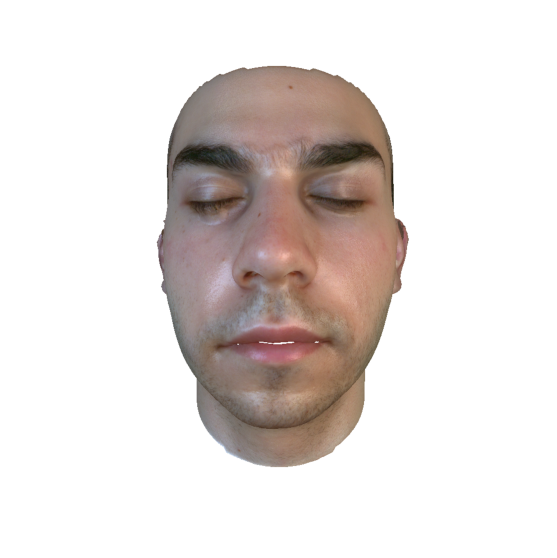

In [99]:
t = time.time()
images = renderer(meshes)
print('took {} seconds'.format(round(time.time()-t, 2)))
show(images[0, ..., :3], figsize=(10,10))